In [ ]:
import numpy as np
import pandas as pd
import geopy.distance
import matplotlib # For plot
import matplotlib.pyplot as plt
from scipy.signal import correlate
import tkinter as tk
from tkinter import *
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import random

### If packages are not found run cell below

In [ ]:
# !pip install scipy
# !pip install geopy
# !pip install tkinter

## Rain Gauge Review notebook (READ ME)

Before you start the analysis, make sure you understand what a working station and a defect station is and how you can see this in a DM-Curve. You can discuss this with your professor/lecturer and you can look at the examples that provided along with this notebook in the **Examples_DMcurve** pdf.

This notebook provides a step by step process to review raingauge data from a specific year. It combines the data from the HII and EWS into one notebook and converts the data to a hourly cumulative instead of measurements per 10 or 15 min. It is important that you have the following files in the **same folder as this notebook**:

1. locations_HII_EWS_combined.xlsx
2. raingauge data HII
3. raingauge data EWS

The first step is to load in the two seperate datafiles from HII and EWS. For this make sure that:

1. You have this notebook and the datafiles in the same folder OR correctly define the path to the files 
2. You correctly change the names of the two raingauge_HII and raingauge_EWS inside your folder to the format used in *load_rain_gauge_data(year)*. **Do not remove the**: str(year). This wil cause the function to not run properly as the year is a input parameter.

It could be possible that if the functions are run, a problem with the date columns occurs. This could be due to the following reasons:

1. The indexcolumn 'Datetime' is written as 'datetime' in the rain_EWS file. Change this inside the CSV file to 'Datetime'
2. The date format is not in the d/m/YEAR 00:00 format in the rain_EWS file. If this is not the case, check which format the dates are in the CSV file and adjust the third line that defines the dateparse to the correct format.

In [ ]:
from datetime import datetime

NROWS = None #None means that the entire file will be loaded in

dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

def load_rain_gauge_data(year):
    '''
    Method to load data from excel files per year.

    @param year int: Year to analyse the data from.

    @return rain_HII DataFrame: HII rain data sampled every 10 mins.
    @return rain_EWS DataFrame: EWS rain data sampled every 15 mins.
    '''

    # Load HII data CHANGE NAME OF FILE!!!
    rain_HII = pd.read_excel('raingauge_HII_Phetchaburi_10min_' + str(year) + '.xlsx', index_col=0, parse_dates=True, nrows=NROWS)

    # Load EWS data CHANGE NAME OF FILE!!!
    
#     rain_EWS = pd.read_csv('EWS_station_phetchaburi_project_15m_' + str(year) + '.csv', index_col=0, parse_dates=['Datetime'], date_format='%d/%m/%Y %H:%M', nrows=NROWS)
    rain_EWS = pd.read_csv('EWS_station_phetchaburi_project_15m_' + str(year) + '.csv', index_col=0, parse_dates=['Datetime'], date_parser=dateparse, nrows=NROWS)

    
    return rain_HII, rain_EWS


def convert_and_merge(rain_HII_10min, rain_EWS_15min):
    '''
    Method to convert HII and EWS dataframes to hours and merge them.

    @param rain_HII_10min DataFrame: HII rain data sampled every 10 mins.
    @param rain_EWS_15min DataFrame: EWS rain data sampled every 15 mins.

    @return rain_merged_60min DataFrame: Combined data sampled every 60 mins.
    '''

    # Convert HII to hours
    rain_HII_60min = rain_HII_10min.resample('H').agg(pd.Series.sum, skipna=False)
    rain_HII_60min.reset_index(inplace=True)

    # Convert EWS to hours
    rain_EWS_60min = rain_EWS_15min.resample('H').agg(pd.Series.sum, skipna=False)
    rain_EWS_60min.reset_index(inplace=True)

    # Merge
    rain_merged_60min = pd.merge(rain_HII_60min, rain_EWS_60min, on='Datetime', how='outer')
    rain_merged_60min.set_index('Datetime', inplace=True)

    return rain_merged_60min


def percentage_station_filter(df, threshold):
    '''
    Method to filter out all stations with too much missing data.

    @param df DataFrame: Rain data to be filtered.
    @param threshold Float: Minimum percentage of values captured by station.

    @return df DataFrame: Rain data without stations with too much missing data.
    '''

    # Count number of columns
    n_col = df.shape[1]
    # Init bad stations list
    bad_st = []

    # Loop over columns
    for i in range(n_col):
        # Get column and count values
        col = df.iloc[:,i]
        total_values = len(col)
        nan_values = col.isna().sum()

        # Compute percentage
        if total_values > 0:
            percentage = 100 - (nan_values / total_values) * 100
        else:
            percentage = 100    # Avoid division by zero if column is empty

        # Bad station if too many missing values 
        if percentage < threshold:
            bad_st.append(col.name)

    # Remove all bad stations
    df.drop(columns=bad_st, inplace=True)

    return df, bad_st


### Loading the files by running the functions

In [ ]:
year = 2022 #Change to the year you want to review

rain_HII, rain_EWS = load_rain_gauge_data(year)
rain_HII_EWS = convert_and_merge(rain_HII, rain_EWS)
rain_data, bad_st = percentage_station_filter(rain_HII_EWS, 40) #Adjust threshold for broken stations if needed

In [ ]:
rain_data.head()

### Export the unfiltered 60 minute merged file to excel

This cell exports the merged 60 minute file to your folder if you want to continue without doing the analysis

In [ ]:
rain_data.to_excel('merged_60min_' + str(year) + '.xlsx')

In [ ]:
rain_sorted = rain_data.sort_index(axis = 1) #Sort data alphabetical

rain_data_daily = rain_sorted.resample('D').sum() #Resample to daily cumulative

column_keys = rain_data_daily.columns.tolist() #Store the column keys in a list for filtering the location matrix

rain_data_daily.head(50)

In [ ]:
a = [16,18,20,24,25,33,37,45,47,50,52,54,57,58,62,68,70,71,73,74,75,79,81,82,84,89,91,94,98,101,103,105,106,107,109,110,112,114,115,119,121,123,126,127,128,130,132,133,134,139,140,141,144,145,146,148,149,150,151,153,155,159,160,161,164,165,166,167,169,171,172,173,176,178,179,182,187,195,200,203,206,208,210,213,217,218,219,221,222,226,228,230,232,234,235,237,248,249,250,251,253,255,256,257,258,259,260,261,300,301,303,305,306,307,308,310,311,313,314,316,317,319,320,321,322,323,324,325,327,328,329,334,335,336,338,339,340,344,346,347,348,349,350,351,352,354,355,359,361,367,368,369,371,372,374,376,377,379,381,386,387,389,390,391,392,393,396,398,402,407,408,410,411,414,415,422,424,427,428,431,432,434,436,437,439,440,441,442,444,445,447,453,454,455,456,457,458,461,464,465,467,469,472,473,475,476,477,480,485,486,631,632,635,638,640,641,642,648,649,650,651,655,656,658,659,660,662,667,668,669,670,671,672,676,677,678,679,681,682,686,687,689,690,691,694,697,700,701,704,705,707,708,711,712,713,714,716,718,721,723,724,730,731,732,735,736,737,738,742,743,748,750,753,754,756,757,758,759,760,761,762,764,765,766,768,770,771,773,778,781,782,788,791,793,794,795,796,798,803,806,807,808,809,813,815,817,820,821,824,826,828,829,832,833,834,837,841,845,847,848,849,852,853,854,855,857,862,864,865,866,867,868,877,878,879,881,882,888,889,890,891,892,893,894,897,898,899,900,901,902,903,906,907,909,910,911,913,915,917,920,921,924,925,929,930,931,932,933,934,935,939,940,941,942,946,947,948,949,951,952,953,954,956,958,959,960,961,962,963,964,965,966,968,973,974,976,980,981,982,983,986,987,988,989,990,991,992,993,996,998,999,1001,1002,1003,1004,1006,1007,1013,1018,1020,1021,1022,1023,1027,1028,1030,1034,1040,1041,1042,1044,1049,1051,1052,1057,1058,1059,1060,1062,1063,1066,1067,1069,1070,1073,1076,1079,1081,1082,1083,1085,1088,1090,1091,1092,1094,1096,1097,1099,1100,1101,1102,1104,1105,1107,1108,1109,1110,1111,1112,1113,1114,1116,1117,1118,1119,1120,1121,1122,1123,1127,1128,1131,1132,1133,1137,1138,1139,1140,1141,1142,1143,1145,1146,1150,1152,1153,1158,1160,1161,1163,1166,1167,1168,1169,1171,1173,1174,1176,1179,1181,1185,1186,1188,1189,1191,1192,1194,1195,1196,1198,1200,1203,1205,1206,1207,1211,1212,1213,1214,1216,1220,1221,1222]

print(len(a))

### Load and filter the location data

This part loads in the combined file of the coordinates of the HII and EWS stations. It is important that the stations that are already excluded by filtering the stations that registered data less than 40% of the time are filtered out of the location matrix. This ensures that everything is the same length and we will not run into any index errors. 

In [ ]:
location_gauges = pd.read_excel('locations_HII_EWS_combined.xlsx', index_col = [0])
location_gauges = location_gauges[~location_gauges.index.duplicated(keep='first')]
location_filtered = location_gauges[location_gauges.index.isin(column_keys)]

empty_gauges = np.empty((len(location_filtered), len(location_filtered)))

for i in range(len(location_filtered)):
    coordinate_1 = (location_filtered['LAT'].iloc[i], location_filtered['LONG'].iloc[i])
    for j in range(i, len(location_filtered)):
        coordinate_2 = (location_filtered['LAT'].iloc[j], location_filtered['LONG'].iloc[j])
        empty_gauges[i, j] = geopy.distance.geodesic(coordinate_1, coordinate_2).km



In [ ]:
index_distances_1 = location_filtered.index

distances_gauges = pd.DataFrame(data = empty_gauges, index = index_distances_1, columns = index_distances_1)
distances_gauges

## Correlation matrix for Kagan analysis

This part computes the correlation factor between the stations. It uses the correlation function of python to do this. The higher the correlation between the two stations, the more likely it is that the stations are close to eachother because a high correlation means the stations measure the same rainfall. 

The final result is an upper triangular matrix in the same shape as the distance matrix. These matrices are important in determining the maximum radius in which stations lie that have a correlation above 0.60 with respect to the station that will be analysed. If the maximum radius is too high, the analysis will be less accurate because stations that did not record the same rain events will be taken into account.

In [ ]:
def correl(station_1, station_2):
    """ Calculates correlation between 2 rain gauges with following parameters:
    array_1 = first rain station
    array_2 = second rain station
    """
    correlation = np.corrcoef(station_1, station_2) #Returns correlation matrix, only diagonal entry is needed so value at 1x2 or 2x1
    return correlation[0,1]

correl(rain_data_daily.iloc[:,10], rain_data_daily.iloc[:,11])

In [ ]:
corr_empty = np.empty((len(location_filtered), len(location_filtered)))

for i in range(len(location_filtered)):
    array_filtered_1 = rain_data_daily.iloc[:, i]
    for j in range(len(location_filtered)):
        array_filtered_2 = rain_data_daily.iloc[:, j]
        corr_empty[i, j] = correl(array_filtered_1, array_filtered_2)

In [ ]:
corr_matrix = pd.DataFrame(data = corr_empty, index = index_distances_1, columns = index_distances_1)
corr_matrix.head()

In [ ]:
corr_matrix *= 1 - np.tri(*corr_matrix.shape, k = -1)
corr_matrix.head()

## Maximum radius

The goal of this is notebook is to plot the Double-Mass curve (DM-curve) for each station. For this, we need the maximum radius that we mentioned in the correlation section. The function below calculates this radius by finding the set of points that has the highest distance to another station but still has a correlation close (but above) 0.6. For example, the function could return two stations with a distance of 80 kilometers but still have a correlation of 0.62. When this happens, the function returns a lower value because a value like 80 kilometers is usually not common in plotting a DM-curve. Instead it returns the predefined allowable radius. This could be changed according to preference. The parameter in the function is called *max_radius_lim*. 

To get a better visual explanaition, run the next two cells for a plot that shows the result. The two **dashed red lines** show you the optimal point. The plotted points should generally follow a decreasing exponential shape. If this is not the case, check if something went wrong during loading the data. The example below is when the correlation and distance plot is not correct. You then see the points scattered along the entire graph.

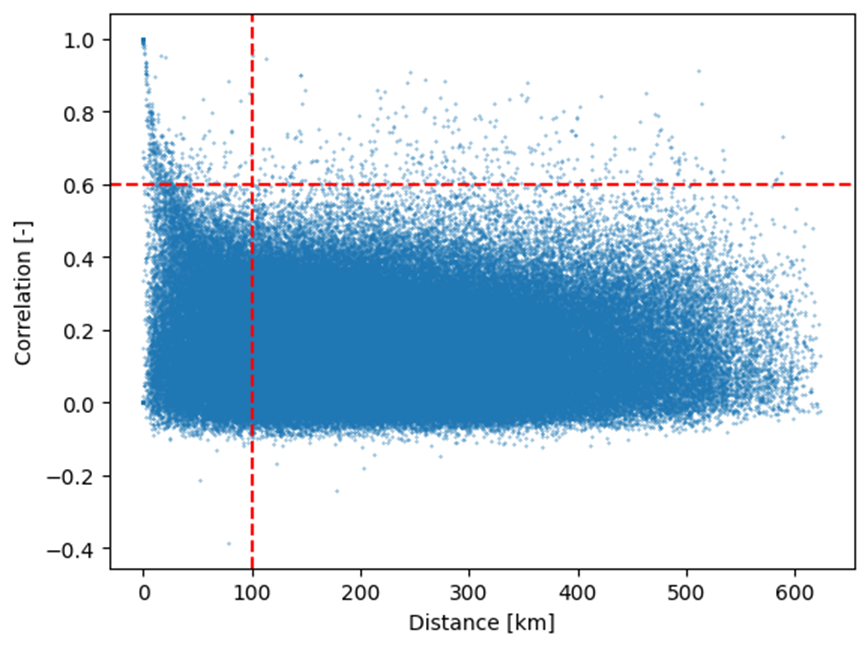

In [ ]:
def maximum_radius(distance_df, correlation_df, min_correlation, max_error, max_radius_lim):
    """
    maximum radius in which 2 stations have a high enough correlation. It has the following input parameters:
    distance_df = the dataframe that is created before with distances between 2 stations
    correlation_df = the dataframe that is created before with correlation between 2 stations
    min_correlation = minimum required acceptable correlation (standard is 0.6)
    max_error = amount of which the point found can deviate from 0.6 
    (max_error = 0.10 means that a correlation value of 0.70 can be found because the radius is higher at this point)
    max_radius_lim = realistic value for maximum radius. If max_radius goes to 600 this is probably not realistic
    """
    stations = [int(i) for i in range(0, len(distance_df))]
    max_distance = -1
    max_distance_stations = None

    for i in range(len(distance_df)):
        for j in range(i+1, len(distance_df)):
            distance = distance_df.iloc[i, j]
            correlation = correlation_df.iloc[i, j]

            if correlation >= min_correlation and abs(correlation - min_correlation) <= max_error:
                if distance > max_distance:
                    max_distance = distance
                    max_distance_stations = (stations[i], stations[j])
                    max_radius = distance_df.iloc[max_distance_stations[0], max_distance_stations[1]]
    max_radius = min(max_radius, max_radius_lim)
    return max_radius

m_r = maximum_radius(distances_gauges, corr_matrix, 0.6, 0.10, 50)
print(maximum_radius(distances_gauges, corr_matrix, 0.6, 0.10, 50))

In [ ]:
plt.scatter(distances_gauges, corr_matrix, s=0.1)

plt.xlabel('Distance [km]')
plt.ylabel('Correlation [-]')
plt.axhline(0.6, c = 'r', ls ='--')
plt.axvline(m_r, c = 'r', ls = '--')


## DM-Curves

In the analysis, each station will be plotted seperately. We call the station that is plotted the **key station**. The DM-curve will be plotted with the function below. The function returns two things:

1. A list per station that contains the surrounding stations that were used in plotting the DM-curve.
2. A list that contains the DM curve. So the cumulative rainfall of the key station and the average cumulative of the surrounding stations.

**DO NOT CHANGE ANYTHING** The function uses predefined input in the form of the matrices that are already calculated. If you run the function, an example graph will be plotted. It could be that the station key is filtered out in the first step. **You should then try a few other stations untill you see a plot.**


In [ ]:
def DM_analysis(distance_df, correlation_df, rain_gauge_df):
    max_radius = maximum_radius(distance_df, correlation_df, 0.6, 0.10, 50)
    
    stations_dict = {}
    
    for index in distance_df.index:
        stations_dict[index] = []
    
    for i in range(len(distance_df)):
        for j in range(i+1, len(distance_df)):
            distance = distance_df.iloc[i, j]
            
            if distance < max_radius:
                station_i = distance_df.index[i]
                station_j = distance_df.index[j]
                
                stations_dict[station_i].append(station_j)
                stations_dict[station_j].append(station_i)
            
    cumulative_rainfall_dict = {}   
    
    # Iterate through the keys (row indices) in stations_dict
    for index, stations in stations_dict.items():
        # Filter relevant columns based on the station's stations_dict entry
        relevant_columns = [station for station in stations if station in rain_gauge_df.columns]
        relevant_data = rain_gauge_df[relevant_columns]
        
        # Calculate the cumulative sum for each column separately
        cumulative_sums = relevant_data.cumsum()
        
        # Calculate the average cumulative sum across relevant columns (including the key column)
        average_cumulative_sum = cumulative_sums.mean(axis=1)
        
        # Store the average cumulative sum and the cumulative sum of the key column
        cumulative_rainfall_dict[index] = {
            'average_cum_sum': average_cumulative_sum,
            'key_column_cum_sum': rain_gauge_df[index].cumsum()  # Assuming index is the key column
        }
    
    return cumulative_rainfall_dict, stations_dict

# # Example usage:
results, surrounding_stations = DM_analysis(distances_gauges, corr_matrix, rain_data_daily)

station_key = 'TTWY'  # Replace with the desired station key
print(results['TTWY'])
# Plotting the average cumulative sum and cumulative sum of the key column
plt.figure(figsize=(10, 6))
plt.plot(results[station_key]['key_column_cum_sum'], results[station_key]['average_cum_sum'], label='Average Cumulative Sum', color='blue')

plt.xlabel('Cumulative Rainfall for' + station_key)
plt.ylabel('Cumulative average Rainfall')
plt.legend()
plt.title('DM curve for' + station_key)
plt.show()

## Checking stations

The code below allows you to look up stations through their key. **DO NOT USE THIS WHEN YOU ARE DOING THE REVIEW FROM THE NEXT PART** Python is running the widget in which you can perform the DM analysis so it will not be able to plot any graphs. You can look up the stations that were difficult to analyse after the review **or before you start it**.

In [ ]:
station_key = 'TTWY'  # Replace with the desired station key
print(results['TTWY'])
# Plotting the average cumulative sum and cumulative sum of the key column
plt.figure(figsize=(10, 6))
plt.plot(results[station_key]['key_column_cum_sum'], results[station_key]['average_cum_sum'], label='Average Cumulative Sum', color='blue')

plt.xlabel('Cumulative Rainfall for' + station_key)
plt.ylabel('Cumulative average Rainfall')
plt.legend()
plt.title('DM curve for' + station_key)
plt.show()

## DM-Curve Analysis

Now the most important part of the notebook: the analysis. The code below generates a window on your computer that is interactive. Inside the window you see a plotted DM-curve with two buttons: *correct* and *defect.*

# **DO NOT CLOSE THIS WINDOW UNTILL YOU HAVE FINISHED!!!**

This is really important. You must go over all the stations in one sit. This does not take more than 10 to 20 minutes. The code creates two lists of working and defect stations. If you shut down the window that plot the graphs before you finish, the lists will not be complete. Instead close the window after you see the message: **No more stations to review**. Do not worry if this takes some time. This is because of the large amount of processing time your computer needed for performing the analysis. Just wait until the window closes and if it gives the error: *'Not responding'* inside your window, just click *'wait until program reacts'*. **DO NOT DOUBLE CLICK ON THE CORRECT OR DEFECT BUTTON AS IT WILL ADD THE LAST STATION TO THE LIST MULTIPLE TIMES**

Before you start the analysis, make sure you understand what a working station and a defect station is. You can discuss this with your professor/lecturer and you can look at the examples I provided along with this notebook. If a station is working you will see a generally good looking line that follows the same angle along the graph. If a station is broken, the line is straight or follows a weird pattern. If you click one of the buttons, the code will plot the next station. **Make sure you do not double click otherwise you will skip stations.**

**If you accidentally close the window or shutdown the notebook. Restart the notebook and run everything again. You have to start over with the analysis.**

In [ ]:
station_keys = column_keys
current_station_number = 0
working_stations = []
defect_stations = []

def plot_station():
    global current_station_number
    if not station_keys:
        label.config(text = "No more stations to review")
        return

    station_key = station_keys.pop(0)
    current_station_number += 1

    # Create a Matplotlib figure and plot
    fig, ax = plt.subplots()
    ax.plot(results[station_key]['key_column_cum_sum'], results[station_key]['average_cum_sum'], label='Average Column', color='blue')
    ax.set_title(f"Review Station: {station_key}")
    ax.set_xlabel(f"Cumulative Rainfall for {station_key} [mm]")
    ax.set_ylabel(f"Cumulative Rainfall for {len(surrounding_stations[station_key])} surrounding stations [mm]")
    
    #Create equal axis
    axis_max = max(max(results[station_key]['key_column_cum_sum']), max(results[station_key]['average_cum_sum']))
    ax.set_xlim(0, axis_max)
    ax.set_ylim(0, axis_max)
    ax.set_aspect('equal')
    ax.grid()
    
    # Embed the Matplotlib plot in the Tkinter window
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.grid(row = 0, column = 0, padx = 10, pady = 10)
    canvas_widget.config(width = 700, height = 700)

    # Button for marking as "Correct"
    correct_button = tk.Button(root, text = "Correct", command = lambda: mark_as_correct(station_key))
    correct_button.grid(row = 1, column = 0, padx = 10, pady = 5)

    # Button for marking as "Defect"
    defect_button = tk.Button(root, text = "Defect", command = lambda: mark_as_defect(station_key))
    defect_button.grid(row = 1, column = 1, padx = 10, pady = 5)
    
    # Label to display the current station number
    station_number_label.config(text=f"Station {current_station_number}/{len(column_keys)}")
    
    label.config(text = f"Reviewing Station: {station_key}")

def mark_as_correct(station_key):
    working_stations.append(station_key)
    next_station()

def mark_as_defect(station_key):
    defect_stations.append(station_key)
    next_station()

def next_station():
    plt.clf()  # Clear the previous plot
    plot_station()

# Create the main Tkinter window
root = tk.Tk()
root.title("DM Curve Review")

label = tk.Label(root, text = "")
label.grid(row = 2, column = 0, columnspan = 2, pady = 10)

# Label to display the current station number
station_number_label = tk.Label(root, text="")
station_number_label.grid(row=3, column=0, columnspan=2, pady=10)


# Start the review process
plot_station()

root.mainloop()

print("Correct Stations:", working_stations)
print("Defect Stations:", defect_stations)

## Exporting to excel

You have now finished the analysis. The last step is exporting it you excel. For this we need to make a few lists. We already have a list of all the working stations and the defect stations you selected in the analysis. We also need to extract the stations that are filtered out in the first step. The result are two excels:

1. An overview of all working and defect stations
2. The completely filtered merged hourly raingauge data. 

The first excel contains the following sheets:

1. **Working stations**: this contains a column with all the working stations, the number of surrounding stations and the list of surrounding stations.
2. **Defect stations**: this contains a column with all the defect stations selected by the DM analysis, the number of surrounding stations and the list of surrounding stations.
3. **Filtered stations**: this contains the stations that are filtered out because they were measuring less than 40% of the time.

In [ ]:
len_amount_surrounding_working = []
labels_surrounding_working = []

for i in range(len(working_stations)):
    len_amount_surrounding_working.append(len(surrounding_stations[working_stations[i]]))
    labels_surrounding_working.append(surrounding_stations[working_stations[i]])
    
len_amount_surrounding_defect = []
labels_surrounding_defect = []

for i in range(len(defect_stations)):
    len_amount_surrounding_defect.append(len(surrounding_stations[defect_stations[i]]))
    labels_surrounding_defect.append(surrounding_stations[defect_stations[i]])

In [ ]:
#Sheet 1 with working stations
dataframe_working = pd.DataFrame(len_amount_surrounding_working, index = working_stations, columns = ['Surrounding_stations'])
dataframe_working.index.name = 'Station'
dataframe_working['Labels_surrounding'] = labels_surrounding_working


#Sheet 2 with defect stations
dataframe_defect = pd.DataFrame(len_amount_surrounding_defect, index = defect_stations, columns = ['Surrounding_stations'])
dataframe_defect.index.name = 'Station'
dataframe_defect['Labels_surrounding'] = labels_surrounding_defect

#Sheet 3 with defect stations

dataframe_filtered = pd.DataFrame(bad_st, columns = ['Filtered_stations'])


In [ ]:
#Write to excel

with pd.ExcelWriter('Overview_perfomance_stations_' + str(year) +'.xlsx') as writer:
    dataframe_working.to_excel(writer, sheet_name =  'Working Stations')
    dataframe_defect.to_excel(writer, sheet_name = 'Defect Stations')
    dataframe_filtered.to_excel(writer, sheet_name = 'Filtered Stations')


In [ ]:
#Write filtered data to new excel file

filtered_data = rain_data[working_stations]
filtered_data.to_excel('rain_gauge_data' + str(year) + '_FILTERED.xlsx')